In [4]:
# Pytorch demo/example nlp, sequence to sequence model with attention
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [16]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F



import time
import math

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data loading and Parsing

In [12]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS
        
    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)
            
    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# unice to ascii, to lowercase, trim punctuation

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalize_string(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

# To read the data file we will split the file into lines, 
# and then split lines into pairs. 
# The files are all English → Other Language, so if we want to 
# translate from Other Language → English I added 
# the reverse flag to reverse the pairs.

def read_language_file(base_path='/ndata/NLP/', lang1='eng', lang2='fra', reverse=False):
    lines = open(base_path + '%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')
    
    lines = [seq.split('CC-BY')[0].strip() for seq in lines]
    
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]
    
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs
    
    
# Loading and trimming the data
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filter_pair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

# The full process for preparing the data is:

#  1) Read text file and split into lines, split lines into pairs
#  2) Normalize text, filter by length and content
#  3) Make word lists from sentences in pairs

def prepare_data(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = read_language_file('/ndata/NLP/', lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs



# Pytorch prep for training data
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]
    
def tensor_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensors_from_pair(pair):
    input_tensor = tensor_from_sentence(input_lang, pair[0])
    target_tensor = tensor_from_sentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [7]:
input_lang, output_lang, pairs = prepare_data('eng', 'fra', True)
print(random.choice(pairs))

Read 170651 sentence pairs
Trimmed to 12761 sentence pairs
Counting words...
Counted words:
fra 4740
eng 3054
['je suis etudiant en droit .', 'i m a law student .']


In [8]:
print(random.choice(pairs))

['je suis fascine par les chats .', 'i m fascinated by cats .']


### The Seq2Seq model

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [20]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Training

* To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the <SOS> token as its first input, and the last hidden state of the encoder as its first hidden state.


* “Teacher forcing” is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input. Using teacher forcing causes it to converge faster but when the trained network is exploited, it may exhibit instability.

In [35]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, E_optim, D_optim, 
          criterion, max_length=MAX_LENGTH):
    
    encoder_hidden = encoder.init_hidden()
    
    E_optim.zero_grad()
    D_optim.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    
    loss = 0
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
    
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = \
                decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            # Teacher forcing
            decoder_input = target_tensor[di]
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
    
    loss.backward()

    E_optim.step()
    D_optim.step()
    
    return loss.item() / target_length

In [36]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))


def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [37]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensors_from_pair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    show_plot(plot_losses)

In [38]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensor_from_sentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.init_hidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]
    
def evaluate_randomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

### Lift off

3m 5s (- 43m 17s) (5000 6%) 2.8925
6m 15s (- 40m 43s) (10000 13%) 2.3345
9m 15s (- 37m 2s) (15000 20%) 2.0264
12m 17s (- 33m 48s) (20000 26%) 1.8055
15m 21s (- 30m 42s) (25000 33%) 1.5989
18m 26s (- 27m 40s) (30000 40%) 1.4193
21m 26s (- 24m 30s) (35000 46%) 1.3111
24m 22s (- 21m 19s) (40000 53%) 1.2007
27m 30s (- 18m 20s) (45000 60%) 1.0792
30m 32s (- 15m 16s) (50000 66%) 1.0006
33m 39s (- 12m 14s) (55000 73%) 0.9243
36m 51s (- 9m 12s) (60000 80%) 0.8733
40m 10s (- 6m 10s) (65000 86%) 0.7860
43m 29s (- 3m 6s) (70000 93%) 0.7500
46m 47s (- 0m 0s) (75000 100%) 0.6880


<Figure size 432x288 with 0 Axes>

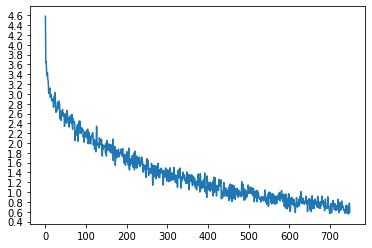

In [39]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [40]:
evaluate_randomly(encoder1, attn_decoder1, n=10)

> vous allez etre jaloux .
= you re going to be jealous .
< you re going to be jealous . <EOS>

> vous etes tous prets .
= you re all set .
< you re all happy . <EOS>

> vous etes pleines de ressources .
= you re very resourceful .
< you re very resourceful . <EOS>

> je suis fatigue par vos plaintes .
= i m tired of your complaints .
< i m tired of your complaints . <EOS>

> je suis presque prete .
= i am almost ready .
< i am almost ready . <EOS>

> nous essayons de gagner .
= we re trying to win .
< we re trying to win . <EOS>

> vous etes sympa .
= you re nice .
< you re nice . <EOS>

> il n est plus celui qu il etait .
= he is not what he used to be .
< he is not what he used to be . <EOS>

> vous etes impartial .
= you re unbiased .
< you are fabulous . <EOS>

> je ne suis pas satisfait .
= i m dissatisfied .
< i m not satisfied . <EOS>

